# cadCAD Tutorials: The Robot and the Marbles Part 5 - Networks

To expand upon our previous examples, we will introduce the concept of using a graph network object that is updated during each state update. The ability to essential embed a graph 'database' into a state is a game changer for scalability, allowing increased complexity with multiple agents or components is represented, easily updated. Below, building upon our previous examples, we will represent the Robots and Marbles example with n boxes, and a variable number of marbles. 

## Behavior and Mechanisms:
* A network of robotic arms is capable of taking a marble from their one of their boxes and dropping it into the other one. 
* Each robotic arm in the network only controls two boxes and they act by moving a marble from one box to the other.
* Each robotic arm is programmed to take one marble at a time from the box containing the most significant number of marbles and drop it in the other box. It repeats that process until the boxes contain an equal number of marbles.
* For our analysis of this system, suppose we are only interested in monitoring the number of marbles in only their two boxes.

In [1]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.configuration import Configuration
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# define global variables
scale=200 # for plotting
T = 25 #iterations in our simulation
boxes=5 #number of boxes in our network
m= 2 #for barabasi graph type number of edges is (n-2)*m

We create a [Barabási–Albert](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model) graph and then fill the 5 boxes with between 1 and 10 balls. You can create as many different nodes or types of nodes as needed

In [2]:
# create graph object with the number of boxes as nodes
network = nx.barabasi_albert_graph(boxes, m)

# add balls to box nodes
for node in network.nodes:
    #network.nodes[node]['type']= "Number of Balls in Box"
    network.nodes[node]['balls'] = np.random.randint(1,10)

In [3]:
nx.write_gpickle(network, 'network.pickle')

Now we will plot the network of boxes and with their labels showing how many balls are in each box.

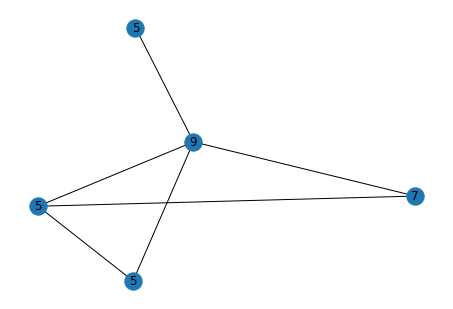

In [4]:
# plot of boxes and balls
nx.draw_kamada_kawai(network,labels=nx.get_node_attributes(network,'balls'))

In [5]:
# we initialize the cadCAD state as a network object
initial_conditions = {'network':'network.pickle'}

In [6]:
#Behavior: node by edge dimensional operator
#input the states of the boxes output the deltas along the edges

# We specify the robotic networks logic in a Policy/Behavior Function
# unlike previous examples our policy controls a vector valued action, defined over the edges of our network
def robotic_network(params, step, sL, s):
    network = nx.read_gpickle(s['network'])
    delta_balls = {}
    for e in network.edges:
        src = e[0]
        dst = e[1]
        #transfer one ball across the edge in the direction of more balls to less
        delta_balls[e] = np.sign(network.nodes[src]['balls']-network.nodes[dst]['balls'])
    return({'delta': delta_balls})

In [7]:
#mechanism: edge by node dimensional operator
#input the deltas along the edges and update the boxes

# We make the state update functions less "intelligent",
# ie. they simply add the number of marbles specified in _input 
# (which, per the policy function definition, may be negative)

def update_network(params, step, sL, s, _input):
    network = nx.read_gpickle(s['network'])
    delta_balls = _input['delta']
    for e in network.edges:
        move_ball = delta_balls[e]
        src = e[0]
        dst = e[1]
        if (network.nodes[src]['balls'] >= move_ball) and (network.nodes[dst]['balls'] >= -move_ball):
            network.nodes[src]['balls'] = network.nodes[src]['balls']-move_ball
            network.nodes[dst]['balls'] = network.nodes[dst]['balls']+move_ball
    path = str(hash(network))+'.pickle'
    nx.write_gpickle(network, path)        
    return ('network', path)

In [8]:
# wire up the mechanisms and states
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'action': robotic_network
        },
        'variables': { # The following state variables will be updated simultaneously
            'network': update_network
            
        }
    }
]

In [9]:
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
simulation_parameters = {
    'T': range(T),
    'N': 1,
    'M': {}
}

In [10]:
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

In [11]:
# Run the simulations
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
df = pd.DataFrame(raw_result)

single_proc: [<cadCAD.configuration.Configuration object at 0x1158d2e10>]


We create some helper functions to extract the networkx graph object from the Pandas dataframe and plot it.

In [12]:
#NetworkX helper functions
def get_nodes(g):
    return [node for node in g.nodes if g.nodes[node]]


def pad(vec, length,fill=True):

    if fill:
        padded = np.zeros(length,)
    else:
        padded = np.empty(length,)
        padded[:] = np.nan
        
    for i in range(len(vec)):
        padded[i]= vec[i]
        
    return padded

def make2D(key, data, fill=False):
    maxL = data[key].apply(len).max()
    newkey = 'padded_'+key
    data[newkey] = data[key].apply(lambda x: pad(x,maxL,fill))
    reshaped = np.array([a for a in data[newkey].values])
    
    return reshaped

Using our helper function get_nodes() we pull out the boxes ball quantity and save it to a new dataframe column.

In [13]:
df['Balls'] = df.network.apply(lambda g: np.array([nx.read_gpickle(g).nodes[j]['balls'] for j in get_nodes(nx.read_gpickle(g))]))

Next we will plot the number of balls in each box over the simulation time period. We can see an oscillation occurs never reaching an equilibrium due to the uneven nature of the boxes and balls.

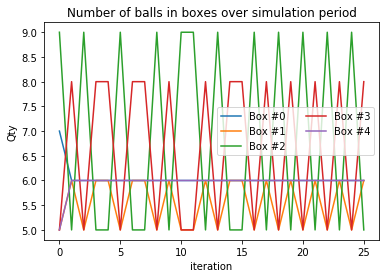

In [14]:
plt.plot(df.timestep,make2D('Balls', df))
plt.title('Number of balls in boxes over simulation period')
plt.ylabel('Qty')
plt.xlabel('iteration')
plt.legend(['Box #'+str(node) for node in range(boxes)], ncol = 2)

In summary, we created a graph network of boxes and robotic arms to transfer balls between the boxes, striving for an unachievable equilibrium state. The ability to embed a graph, virtually a graph database, into a cadCAD state allows for tremendous scalability and flexibility as a modeling tool.  

In [15]:
df

,network,run,substep,timestep,Balls,padded_Balls
0,network.pickle,1,0,0,"[7, 5, 9, 5, 5]","[7.0, 5.0, 9.0, 5.0, 5.0]"
1,291000212.pickle,1,1,1,"[6, 6, 5, 8, 6]","[6.0, 6.0, 5.0, 8.0, 6.0]"
2,-9223372036563775600.pickle,1,1,2,"[6, 5, 9, 5, 6]","[6.0, 5.0, 9.0, 5.0, 6.0]"
3,291000219.pickle,1,1,3,"[6, 6, 5, 8, 6]","[6.0, 6.0, 5.0, 8.0, 6.0]"
4,291000205.pickle,1,1,4,"[6, 6, 5, 8, 6]","[6.0, 6.0, 5.0, 8.0, 6.0]"
5,-9223372036563775607.pickle,1,1,5,"[6, 5, 9, 5, 6]","[6.0, 5.0, 9.0, 5.0, 6.0]"
6,-9223372036563775586.pickle,1,1,6,"[6, 6, 5, 8, 6]","[6.0, 6.0, 5.0, 8.0, 6.0]"
7,291000226.pickle,1,1,7,"[6, 6, 5, 8, 6]","[6.0, 6.0, 5.0, 8.0, 6.0]"
8,291000240.pickle,1,1,8,"[6, 5, 9, 5, 6]","[6.0, 5.0, 9.0, 5.0, 6.0]"
9,-9223372036563775558.pickle,1,1,9,"[6, 6, 5, 8, 6]","[6.0, 6.0, 5.0, 8.0, 6.0]"
